In this tutorial we will analyze the cluster mass function and the halo bias using classes [NcHaloMassFunction](https://numcosmo.github.io/manual/NcHaloMassFunction.html) and [Halo Bias Function Type](https://numcosmo.github.io/manual/ch08s06.html) of the [Large Scale Structure](https://numcosmo.github.io/manual/ch08.html) module of the NumCosmo library, for comparison purposes we will also be using the Colossus (COsmology, haLO, and large-Scale StrUcture toolS) library. 

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import numpy as np
import sys
import math 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 12

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from colossus.cosmology import cosmology
from colossus.lss import mass_function
from colossus.lss import bias

In [2]:
params = cosmology.cosmologies['planck18']
params['de_model'] = 'w0wa'
params['w0'] = -0.8
params['wa'] = 0.1
#params['interpolation'] = False
params['persistence'] = ''

cosmo_col = cosmology.setCosmology('planck_w0wa', params)
#cosmo_col = cosmology.setCosmology('planck18');

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w0",        cosmo_col.w0)
cosmo.param_set_by_name ("w1",        cosmo_col.wa)
cosmo.param_set_by_name ("Omegab",    cosmo_col.Ob0)
cosmo.param_set_by_name ("Omegac",    (cosmo_col.Om0 - cosmo_col.Ob0))
#cosmo.param_set_by_name ("massnu_0",  Planck13.m_nu.value[2])
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff)
#cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff - 3.0*cosmo.E2Press_mnu(1.0e10) / (cosmo.E2Omega_g(1.0e10) * (7/8*(4/11)**(4/3))))
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)

### Halo mass function

The function [`nc_halo_mass_function_new ()`](https://numcosmo.github.io/manual/NcHaloMassFunction.html#nc-halo-mass-function-new) allocates memory for a new [NcHaloMassFunction](https://numcosmo.github.io/manual/NcHaloMassFunction.html) object and sets its properties to the values from the input arguments. In the Press-Shechter theory the mass function is given by

\begin{equation}
    n(M)\,dM  = -\frac{\bar{\rho}}{M}f_{PS}(\nu)\frac{1}{\sigma_R(z)}\frac{\,d\sigma_R(z)}{\,dM},
\end{equation}

being $f_{PS}(\nu)$ the multiplicity function

\begin{equation}
    f_{PS}(\nu) = \sqrt{\frac{2}{\pi}}\big(\delta_c\sigma^{-1}_R\exp{[-\delta^2_c\sigma^{-2}_R/2]}\big) = \sqrt{\frac{2}{\pi}}\nu e^{-\nu^2/2}.
\end{equation}

Note that $f_{PS}$ depends on $\sigma^{-1}_R$ and $\delta_c$, so before we define [`nc_halo_mass_function_new ()`](https://numcosmo.github.io/manual/NcHaloMassFunction.html#nc-halo-mass-function-new) we need to designate the classes [NcDistance](https://numcosmo.github.io/manual/NcDistance.html), [NcmPowspecFilter](https://numcosmo.github.io/manual/NcmPowspecFilter.html) and [NcMultiplicityFunc](https://numcosmo.github.io/manual/NcMultiplicityFunc.html).

In [3]:
reion  = Nc.HIReionCamb.new ()
prim   = Nc.HIPrimPowerLaw.new ()

cosmo.add_submodel (reion)
cosmo.add_submodel (prim)

tf = Nc.TransferFuncEH.new ()
psml  = Nc.PowspecMLTransfer.new (tf)

# Redshift bounds
z_min = 0.0
z_max = 2.0
zdiv  = 0.49999999999

# Mode bounds
k_min = 1.0e-5
k_max = 1.0e3

nk = 2000

psml.set_kmin (k_min)
psml.set_kmax (k_max)
psml.require_zi (z_min)
psml.require_zf (z_max)

prim.param_set_by_name ("n_SA", cosmo_col.ns)
reion.param_set_by_name ("z_re", 9.9999)

# Prepares the power spectrum using the cosmological model.
psml.prepare (cosmo)

old_logAs = prim.param_get_by_name ("ln10e10ASA") 
a         = 2.0 * math.log (cosmo_col.sigma8 / psml.sigma_tophat_R (cosmo, 1.0e-7, 0.0, 8.0 / cosmo.h ()))
new_logAs = old_logAs + a

prim.param_set_by_name ("ln10e10ASA", new_logAs)

cosmo_col = cosmology.getCurrent()

#
#  New cosmological distance objects optimizied to perform calculations
#  up to redshift 2.0.
#
dist = Nc.Distance.new (2.0)

#
# Apply a tophat filter to the psml object, set best output interval.
#
psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

#
# Multiplicity functions
#
mulf = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncPS")
mulf1 = Nc.MultiplicityFunc.new_from_name("NcMultiplicityFuncST")
mulf2 = Nc.MultiplicityFunc.new_from_name("NcMultiplicityFuncJenkins")
mulf3 = Nc.MultiplicityFunc.new_from_name("NcMultiplicityFuncWarren")
mulf4 = Nc.MultiplicityFunc.new_from_name("NcMultiplicityFuncCrocce")

#
# New mass function object using the objects defined above.
#
mf = Nc.HaloMassFunction.new (dist, psf, mulf)
mf1 = Nc.HaloMassFunction.new(dist, psf, mulf1)
mf2 = Nc.HaloMassFunction.new(dist, psf, mulf2)
mf3 = Nc.HaloMassFunction.new(dist, psf, mulf3)
mf4 = Nc.HaloMassFunction.new(dist, psf, mulf4)

In [4]:
mset = Ncm.MSet.new_array ([cosmo])
mset.pretty_log ()

#----------------------------------------------------------------------------------
# Model[01000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.66               [FIXED]
#   -     Omegac[01]:  0.2621              [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.7255              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.049               [FIXED]
#   -         w0[07]: -0.8                 [FIXED]
#   -         w1[08]:  0.1                 [FIXED]
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

There are several models for the multiplicity function implemented in NumCosmo, here we only use the [NcMultiplicityFuncPS](https://numcosmo.github.io/manual/NcMultiplicityFuncPS.html), [NcMultiplicityFuncST](https://numcosmo.github.io/manual/NcMultiplicityFuncST.html), [NcMultiplicityFuncJenkins](https://numcosmo.github.io/manual/NcMultiplicityFuncJenkins.html), [NcMultiplicityFuncWarren](https://numcosmo.github.io/manual/NcMultiplicityFuncWarren.html) and the [NcMultiplicityFuncCrocce](https://numcosmo.github.io/manual/NcMultiplicityFuncCrocce.html) models, which coincide with the models present in Colossus.

<Figure size 432x288 with 0 Axes>

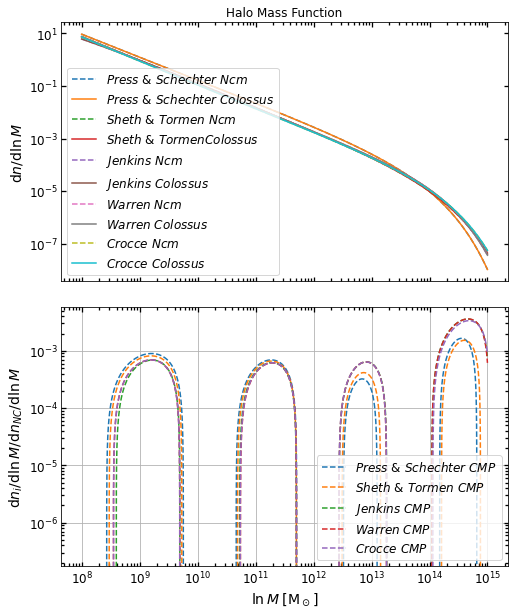

In [9]:
mf.set_area_sd (200.0)
mf.set_eval_limits (cosmo, math.log (1e14), math.log(1e16), 0.0, 2.0)
mf.prepare (cosmo)

M = 10**np.arange(8.0, 15.0, 0.001)
z = 0.7

dn_dlnM_nc = []
dn_dlnM_col = []

dn_dlnM_nc1 = []
dn_dlnM_col1 = []

dn_dlnM_nc2 = []
dn_dlnM_col2 = []

dn_dlnM_nc3 = []
dn_dlnM_col3 = []

dn_dlnM_nc4 = []
dn_dlnM_col4 = []

for M_i in M:
    
    dn_dlnMa_nc = mf.dn_dlnM (cosmo, np.log(M_i), z) 
    dn_dlnM_nc.append (dn_dlnMa_nc)
    
    dn_dlnMa_col = mass_function.massFunction(M_i*cosmo.h(), z, mdef = 'fof', model = 'press74', q_out = 'dndlnM')
    dn_dlnM_col.append (dn_dlnMa_col*(cosmo.h()**3))
    
        
    dn_dlnMa_nc1 = mf1.dn_dlnM (cosmo, np.log(M_i), z) 
    dn_dlnM_nc1.append (dn_dlnMa_nc1)
    
    dn_dlnMa_col1 = mass_function.massFunction(M_i*cosmo.h(), z, mdef = 'fof', model = 'sheth99', q_out = 'dndlnM')
    dn_dlnM_col1.append (dn_dlnMa_col1*(cosmo.h()**3))
    
        
    dn_dlnMa_nc2 = mf2.dn_dlnM (cosmo, np.log(M_i), z) 
    dn_dlnM_nc2.append (dn_dlnMa_nc2)
    
    dn_dlnMa_col2 = mass_function.massFunction(M_i*cosmo.h(), z, mdef = 'fof', model = 'jenkins01', q_out = 'dndlnM')
    dn_dlnM_col2.append (dn_dlnMa_col2*(cosmo.h()**3))
    
    dn_dlnMa_nc3 = mf3.dn_dlnM (cosmo, np.log(M_i), z) 
    dn_dlnM_nc3.append (dn_dlnMa_nc3)
    
    dn_dlnMa_col3 = mass_function.massFunction(M_i*cosmo.h(), z, mdef = 'fof', model = 'warren06', q_out = 'dndlnM')
    dn_dlnM_col3.append (dn_dlnMa_col3*(cosmo.h()**3))
    
    dn_dlnMa_nc4 = mf4.dn_dlnM (cosmo, np.log(M_i), z) 
    dn_dlnM_nc4.append (dn_dlnMa_nc4)
    
    dn_dlnMa_col4 = mass_function.massFunction(M_i*cosmo.h(), z, mdef = 'fof', model = 'crocce10', q_out = 'dndlnM')
    dn_dlnM_col4.append (dn_dlnMa_col4*(cosmo.h()**3))
    
    
dn_dlnM_col_array = np.array(dn_dlnM_col)
dn_dlnM_nc_array = np.array(dn_dlnM_nc)

dn_dlnM_col1_array = np.array(dn_dlnM_col1)
dn_dlnM_nc1_array = np.array(dn_dlnM_nc1)

dn_dlnM_col2_array = np.array(dn_dlnM_col2)
dn_dlnM_nc2_array = np.array(dn_dlnM_nc2)

dn_dlnM_col3_array = np.array(dn_dlnM_col3)
dn_dlnM_nc3_array = np.array(dn_dlnM_nc3)

dn_dlnM_col4_array = np.array(dn_dlnM_col4)
dn_dlnM_nc4_array = np.array(dn_dlnM_nc4)

plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1},figsize=(8,10))

axs[0].set_title ("Halo Mass Function")
axs[0].plot (M, dn_dlnM_nc, '--', label='$Press\ & \ Schechter \ Ncm$')
axs[0].plot (M, dn_dlnM_col, '-', label='$Press\ & \ Schechter \ Colossus$')

axs[0].plot (M, dn_dlnM_nc1, '--', label='$Sheth\ & \ Tormen\ Ncm$')
axs[0].plot (M, dn_dlnM_col1, '-', label='$Sheth\ & \ Tormen Colossus$')

axs[0].plot (M, dn_dlnM_nc2, '--', label='$Jenkins\ Ncm$')
axs[0].plot (M, dn_dlnM_col2, '-', label='$Jenkins\ Colossus$')

axs[0].plot (M, dn_dlnM_nc3, '--', label='$Warren\ Ncm$')
axs[0].plot (M, dn_dlnM_col3, '-', label='$Warren\ Colossus$')

axs[0].plot (M, dn_dlnM_nc4, '--', label='$Crocce\ Ncm$')
axs[0].plot (M, dn_dlnM_col4, '-', label='$Crocce\ Colossus$')

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel('${\mathrm{d}n}/{\mathrm{d}\ln M}$')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')
axs[1].grid()

#axs[1].plot(M, x_list)
axs[1].plot(M,((dn_dlnM_col_array/dn_dlnM_nc_array - 1.0)), '--', label= '$Press\ & \ Schechter \ CMP$')
axs[1].plot(M,((dn_dlnM_col1_array/dn_dlnM_nc1_array - 1.0)),'--', label= '$Sheth\ & \ Tormen \ CMP$')
axs[1].plot(M,((dn_dlnM_col2_array/dn_dlnM_nc2_array - 1.0)),'--', label= '$Jenkins \ CMP$')
axs[1].plot(M,((dn_dlnM_col3_array/dn_dlnM_nc3_array - 1.0)),'--', label= '$Warren \ CMP$')
axs[1].plot(M,((dn_dlnM_col4_array/dn_dlnM_nc4_array - 1.0)),'--', label= '$Crocce \ CMP$')
axs[1].set_yscale ('log')
axs[1].set_ylabel('${\mathrm{d}n_i}/{\mathrm{d}\ln M}$/${\mathrm{d}n_{NC}}/{\mathrm{d}\ln M}$')
axs[1].set_xlabel('$\ln M \; [\mathrm{M}_\odot]$')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)

plt.savefig("halomass_second.pdf", dpi=300, bbox_inches="tight")

### Halo Bias

Halo bias quantifies the excess clustering of halos over the clustering of dark matter. NumCosmo implements four halo bias models, but only two of them match the models presented by colossus, namely [NcHaloBiasTypeSTEllip](https://numcosmo.github.io/manual/NcHaloBiasTypeSTEllip.html) and [NcHaloBiasTypeTinker](https://numcosmo.github.io/manual/NcHaloBiasTypeTinker.html). In this notebook we calculate the bias in two ways, one by defining sigma as a certain interval and another in which we use the [`ncm_powspec_sigma_tophat_R ()`](https://numcosmo.github.io/manual/NcmPowspec.html#ncm-powspec-sigma-tophat-R) function to calculate the value of sigma. Another important point is that the Colossus library calculates in terms of peak height, while NumCosmo does it in terms of $\sigma$, so it was necessary to use the $\nu \equiv \delta_c/\sigma$  relation to make the comparisons correctly.

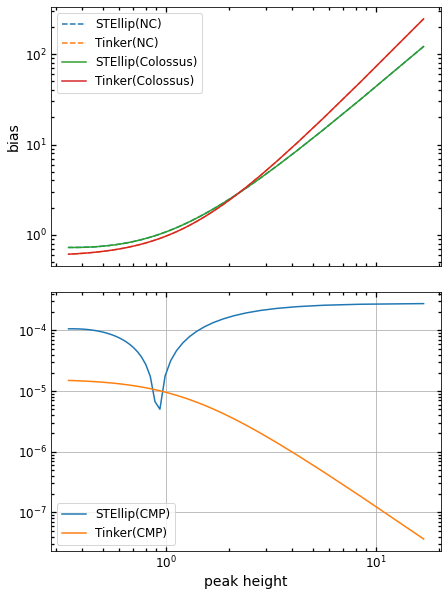

In [11]:
biasf1 = Nc.HaloBiasType.new_from_name ("NcHaloBiasTypePS")
biasf2 = Nc.HaloBiasType.new_from_name ("NcHaloBiasTypeSTEllip")
biasf3 = Nc.HaloBiasType.new_from_name("NcHaloBiasTypeSTSpher") 
biasf4 = Nc.HaloBiasType.new_from_name("NcHaloBiasTypeTinker") 

mdef = '200m'
z = 0.0
sigma = np.arange(0.1, 5.0, 0.1)
nu = 1.686/sigma

halo_bias1_list = []
halo_bias2_list = []
halo_bias3_list = []
halo_bias4_list = []

for sigma_i in sigma:
    halo_bias1 = biasf1.eval (sigma_i, z)
    halo_bias1_list.append(halo_bias1)
    
    halo_bias2 = biasf2.eval (sigma_i, z)
    halo_bias2_list.append(halo_bias2)
    
    halo_bias3 = biasf3.eval (sigma_i, z)
    halo_bias3_list.append(halo_bias3)
    
    halo_bias4 = biasf4.eval (sigma_i, z)
    halo_bias4_list.append(halo_bias4)
    
    
halo_bias2_array = np.array(halo_bias2_list)
halo_bias4_array = np.array(halo_bias4_list)


bias_model1 = bias.haloBiasFromNu(nu, z, mdef, model = "sheth01")
bias_model2 = bias.haloBiasFromNu(nu, z, mdef, model = "tinker10")

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(7,10))
axs[1].set_xlabel('peak height')
axs[0].set_ylabel('bias')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
#plt.plot(nu, halo_bias1_list, '-', label = 'PS(NC)')
axs[0].plot(nu, halo_bias2_list, '--', label = 'STEllip(NC)')
#plt.plot(nu, halo_bias3_list, '-', label = 'STSpher(NC)')
axs[0].plot(nu, halo_bias4_list, '--', label = 'Tinker(NC)')
axs[0].plot(nu, bias_model1, '-', label = "STEllip(Colossus)")
axs[0].plot(nu, bias_model2, '-', label = "Tinker(Colossus)")
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best');

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot(nu, np.abs(bias_model1/halo_bias2_array -1.0), '-', label = "STEllip(CMP)")
axs[1].plot(nu, np.abs(bias_model2/halo_bias4_array -1.0), '-', label = "Tinker(CMP)")
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True);

plt.savefig("halobias_second.pdf", dpi=300, bbox_inches="tight")

In [12]:
import time

psf_gauss = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.GAUSS)
psf_gauss.prepare(cosmo)

In [13]:
R_list  = 10**np.arange(0,2.4,0.005)
nc_sigma_list = []
nc_sigma_gauss_list = []

for R in R_list:
    s0 = time.time()
    nc_sigma_gauss = psf_gauss.eval_sigma(0.0, R)
    nc_sigma_gauss_list.append(nc_sigma_gauss)
    s1 = time.time()
    
    nc_sigma = psml.sigma_tophat_R(cosmo, 1e-6, 0.0, R)
    nc_sigma_list.append(nc_sigma)
    s2 = time.time()
    
col_sigma = cosmo_col.sigma(R=R_list*cosmo.h(), z=0.0, kmin=1.0e-5, kmax=1.0e3)
s3 = time.time()
# I had to multiplie R by cosmo.h cause in Colossus the distances are given in Mpc/h.
col_sigma_gauss = cosmo_col.sigma(R=R_list*cosmo.h(), z=0.0, filt = 'gaussian', kmin=1.0e-5, kmax=1.0e3)
s4 = time.time()

nc_sigma_gauss_array = np.array(nc_sigma_gauss_list)
nc_sigma_array = np.array(nc_sigma_list)

<Figure size 432x288 with 0 Axes>

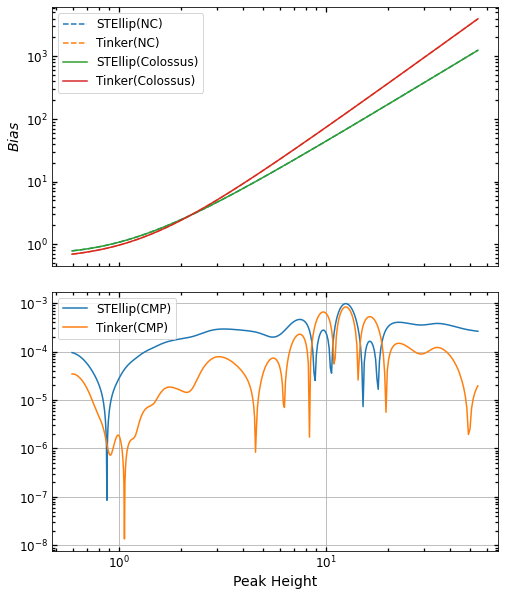

In [14]:
biasf1 = Nc.HaloBiasType.new_from_name ("NcHaloBiasTypePS")
biasf2 = Nc.HaloBiasType.new_from_name ("NcHaloBiasTypeSTEllip")
biasf3 = Nc.HaloBiasType.new_from_name("NcHaloBiasTypeSTSpher") 
biasf4 = Nc.HaloBiasType.new_from_name("NcHaloBiasTypeTinker") 

mdef = '200m'
z = 0.0
sigma = nc_sigma_array #np.arange(0.1, 5.0, 0.1)
nu = 1.686/col_sigma

halo_bias1_list = []
halo_bias2_list = []
halo_bias3_list = []
halo_bias4_list = []

for sigma_i in sigma:
    halo_bias1 = biasf1.eval (sigma_i, z)
    halo_bias1_list.append(halo_bias1)
    
    halo_bias2 = biasf2.eval (sigma_i, z)
    halo_bias2_list.append(halo_bias2)
    
    halo_bias3 = biasf3.eval (sigma_i, z)
    halo_bias3_list.append(halo_bias3)
    
    halo_bias4 = biasf4.eval (sigma_i, z)
    halo_bias4_list.append(halo_bias4)
    
    
halo_bias2_array = np.array(halo_bias2_list)
halo_bias4_array = np.array(halo_bias4_list)

bias_model1 = bias.haloBiasFromNu(nu, z, mdef, model = "sheth01")
bias_model2 = bias.haloBiasFromNu(nu, z, mdef, model = "tinker10")

plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(8,10))

axs[0].loglog()
axs[0].plot(nu, halo_bias2_list, '--', label = 'STEllip(NC)')
axs[0].plot(nu, halo_bias4_list, '--', label = 'Tinker(NC)')
axs[0].plot(nu, bias_model1, '-', label = "STEllip(Colossus)")
axs[0].plot(nu, bias_model2, '-', label = "Tinker(Colossus)")
axs[0].set_ylabel('$Bias$')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[0].legend(loc='best')

axs[1].set_yscale ('log')
axs[1].set_xlabel("Peak Height")
axs[1].plot(nu, np.abs(bias_model1/halo_bias2_array -1.0), '-', label = "STEllip(CMP)")
axs[1].plot(nu, np.abs(bias_model2/halo_bias4_array -1.0), '-', label = "Tinker(CMP)")
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='minor', direction='in', right=True, top=True, length=3.0, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)

#plt.savefig("")